跟上次作业一样，还是手写数字识别，上次我们是把已有的训练好的参数直接用于神经网络，这次我们将利用神经网络的反向传播来训练参数并得到最终的优化模型。

数据集：ex4data1.mat

初始参数：ex4weights.mat

## 1. 构造数据集

1.导入库与数据集：

In [2]:
import numpy as np                  # 科学计算库，处理多维数组，进行数据分析
import matplotlib.pyplot as plt     # 提供一个类似 Matlab 的绘图框架
import scipy.io as sio              # 数据输入输出，用于读入.mat文件。scipy一个高级的科学计算库，它和Numpy联系很密切
from scipy.optimize import minimize # 优化函数

data = sio.loadmat('ex4data1.mat')

2.获取输入变量X：

In [3]:
raw_X = data['X']
X = np.insert(raw_X,0,values=1,axis=1)
X.shape

(5000, 401)

3.获取输出变量y： 注意需要对y进行独热编码处理(one-hot编码)
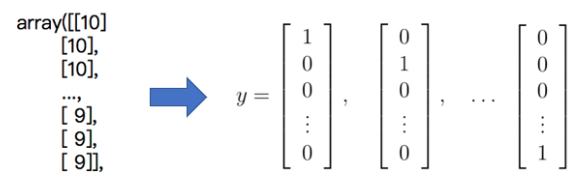

In [4]:
raw_y = data['y']

def one_hot_encoder(raw_y):
    
    result = []
    
    for i in raw_y: # 1-10
        y_temp = np.zeros(10)
        y_temp[i-1] = 1 
        
        result.append(y_temp)
        
    return np.array(result)

y = one_hot_encoder(raw_y)
y.shape

(5000, 10)

4.权重参数θ：

In [19]:
# 1.获取训练参数
theta = sio.loadmat('ex4weights.mat')
print(theta.keys())

theta1, theta2 = theta['Theta1'],theta['Theta2']
print(theta1.shape,theta2.shape)

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])
(25, 401) (10, 26)


In [6]:
# 2.序列化权重参数：将θ1和θ2合并转化为一维数组
def serialize(a,b): 
    return np.append(a.flatten(),b.flatten())  

theta_serialize = serialize(theta1,theta2)  # 将theta1和theta2拉直
theta_serialize.shape

(10285,)

In [7]:
# 3.解序列化权重参数：还原上一步的操作
def deserialize(theta_serialize):
    theta1 = theta_serialize[:25*401].reshape(25,401)
    theta2 = theta_serialize[25*401:].reshape(10,26)
    return theta1,theta2

theta1,theta2 = deserialize(theta_serialize)
theta1.shape,theta2.shape

((25, 401), (10, 26))

## 2.前向传播（和上次的一样）

In [8]:
# 定义激活函数
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [9]:
# 定义前向传播的输入层、隐藏层、输出层
def feed_forward(theta_serialize,X):
    theta1,theta2 = deserialize(theta_serialize)
    a1 = X
    z2 = a1 @ theta1.T
    a2 = sigmoid(z2)
    a2 = np.insert(a2,0,values=1,axis=1)
    z3 = a2 @ theta2.T
    h = sigmoid(z3)
    return a1,z2,a2,z3,h

## 3.代价函数

1.无正则化的代价函数
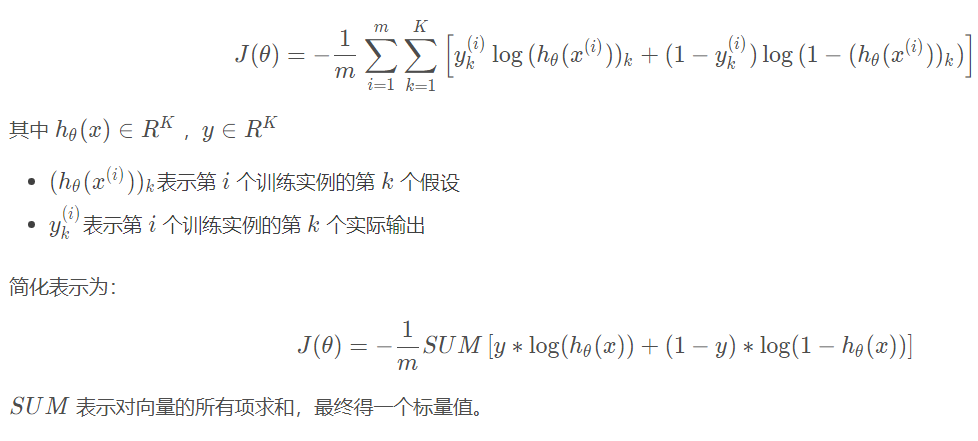

In [10]:
def cost(theta_serialize,X,y):
    a1,z2,a2,z3,h = feed_forward(theta_serialize,X)
    J = -np.sum(y*np.log(h)+(1-y)*np.log(1-h)) / len(X)
    return J

cost(theta_serialize,X,y)

0.2876291651613189

2.有正则化的代价函数
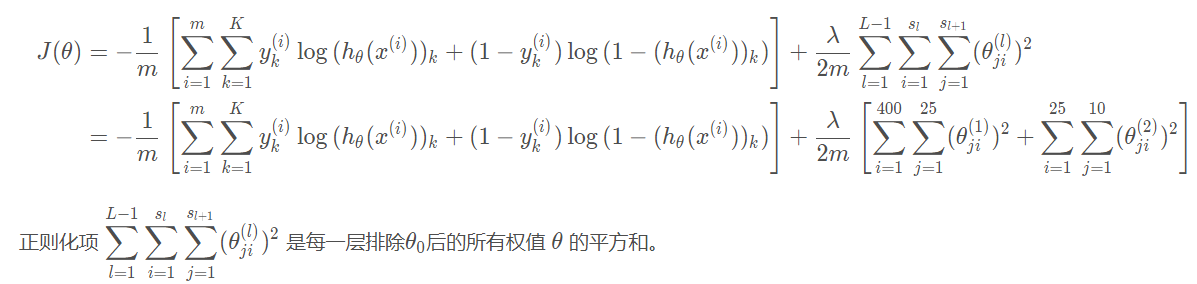

In [11]:
def reg_cost(theta_serialize,X,y,lamda):
    sum1 = np.sum(np.power(theta1[:,1:],2))   # 注意从1开始
    sum2 = np.sum(np.power(theta2[:,1:],2))
    reg = (sum1 + sum2) * lamda / (2*len(X))
    return reg + cost(theta_serialize,X,y)   # 注意返回值加上了cost()

lamda = 1
reg_cost(theta_serialize,X,y,lamda)

0.38376985909092365

## 4.反向传播——梯度矩阵 D

1.无正则化的梯度
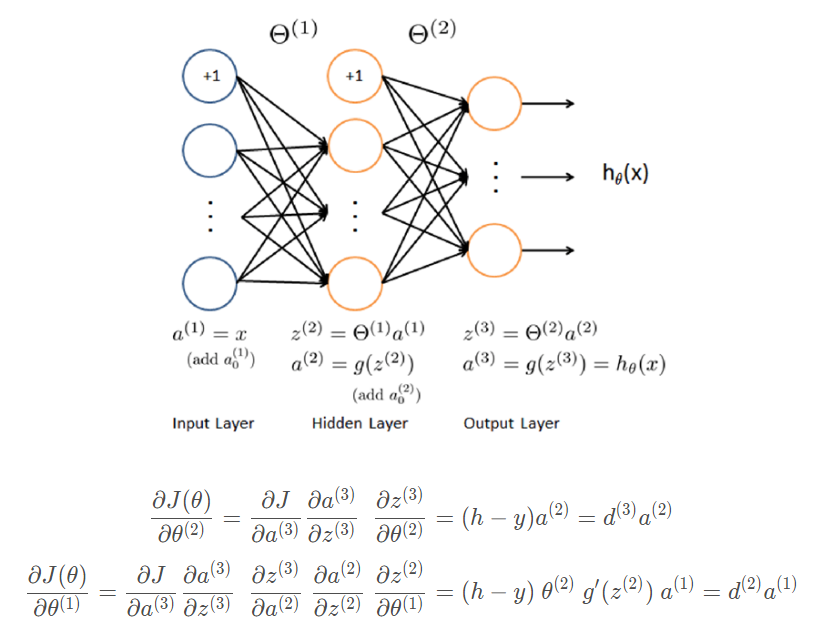

In [12]:
# sigmoid函数求导
def sigmoid_gradient(z):
    return sigmoid(z)*(1-sigmoid(z))

In [13]:
# 对照公式即可 
def gradient(theta_serialize,X,y):
    theta1,theta2 = deserialize(theta_serialize)
    a1,z2,a2,z3,h = feed_forward(theta_serialize,X)
    d3 = h - y
    d2 = d3 @ theta2[:,1:] * sigmoid_gradient(z2)
    D2 = (d3.T @ a2) / len(X)
    D1 = (d2.T @ a1) / len(X)
    return serialize(D1,D2)

2.有正则化的梯度
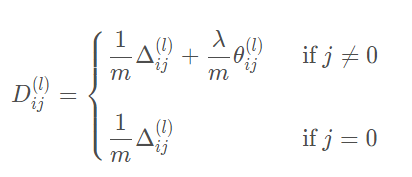

In [14]:
# 对照公式即可
def reg_gradient(theta_serialize,X,y,lamda):
    D = gradient(theta_serialize,X,y)
    D1,D2 = deserialize(D)
    
    theta1,theta2 = deserialize(theta_serialize)
    D1[:,1:] = D1[:,1:]  + theta1[:,1:] * lamda / len(X)
    D2[:,1:] = D2[:,1:]  + theta2[:,1:] * lamda / len(X)
    
    return serialize(D1,D2)

## 5.神经网络训练过程

1.定义优化函数

【注】:

scipy.optimize.minimize(fun, x0, args=(), method='TNC', jac=None, bounds=None, tol=None, callback=None, options={'eps': 1e-08, 'scale': None, 'offset': None, 'mesg_num': None, 'maxCGit': - 1, 'maxiter': None, 'eta': - 1, 'stepmx': 0, 'accuracy': 0, 'minfev': 0, 'ftol': - 1, 'xtol': - 1, 'gtol': - 1, 'rescale': - 1, 'disp': False, 'finite_diff_rel_step': None, 'maxfun': None})

Minimize a scalar function of one or more variables using a truncated Newton (TNC) algorithm.

In [21]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

In [15]:
from scipy.optimize import minimize

# nn_training这个函数定义了整个神经网络训练的全过程（使用了我们之前定义的代价函数、梯度下降函数）
def nn_training(X,y):
    
    # 权值随机初始化 
    init_theta = np.random.uniform(-0.5,0.5,10285) 
    
    # 最小化代价函数（minimize是一个最小化的方法）
    res = minimize(fun =reg_cost,                  # 目标：最小化的函数是reg_cost（有正则项的代价函数）
                   x0 = init_theta,                # x0 的值是随机初始化的
                  args = (X,y,lamda),              # 各个参数
                  method='TNC',                    # 截断牛顿法（不了解）
                  jac = reg_gradient,              # 梯度下降的方式；无正则化就用gradient
                options = {'maxiter':300})         # 可选项：最大迭代次数，选择为300次 
    
    return res                                    # 返回最小化的结果（即，theta_final）

2.计算网络准确率

In [23]:
help(np.argmax)

Help on function argmax in module numpy:

argmax(a, axis=None, out=None)
    Returns the indices of the maximum values along an axis.
    
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int, optional
        By default, the index is into the flattened array, otherwise
        along the specified axis.
    out : array, optional
        If provided, the result will be inserted into this array. It should
        be of the appropriate shape and dtype.
    
    Returns
    -------
    index_array : ndarray of ints
        Array of indices into the array. It has the same shape as `a.shape`
        with the dimension along `axis` removed.
    
    See Also
    --------
    ndarray.argmax, argmin
    amax : The maximum value along a given axis.
    unravel_index : Convert a flat index into an index tuple.
    take_along_axis : Apply ``np.expand_dims(index_array, axis)`` 
                      from argmax to an array as if by calling max.
    
    Notes
    ---

In [25]:
lamda=10
res = nn_training(X,y)

raw_y = data['y'].reshape(5000,)

# 使用之前定义的前向传播算法(使用的是学习了之后的theta值即：theta_final)
_,_,_,_,h = feed_forward(res.x,X)  # 我们只需要最后的结果h ，前面的a1...都不需要

# 预测值
y_pred = np.argmax(h,axis=1) + 1

# 得分
acc = np.mean(y_pred == raw_y)
print(acc)

0.9336


## 6.可视化隐藏层

In [17]:
def plot_hidden_layer(theta):
    theta1,_ = deserialize(theta)
    hidden_layer = theta1[:,1:] # 25,400
    
    
    fig,ax = plt.subplots(ncols=5,nrows=5,figsize=(8,8),sharex=True,sharey=True)
    
    for r in range(5):
        for c in range(5):
            
            ax[r,c].imshow(hidden_layer[5 * r + c].reshape(20,20).T,cmap='gray_r')
            
    
    plt.xticks([])
    plt.yticks([])
    
    plt.show

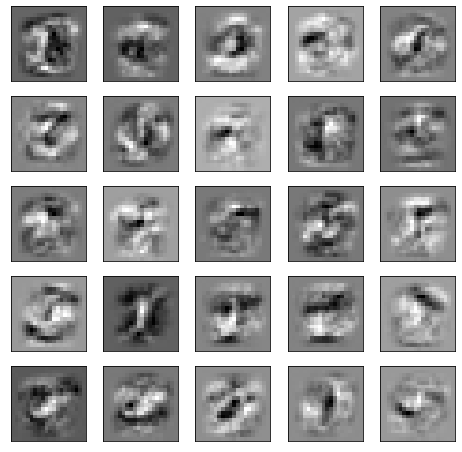

In [18]:
plot_hidden_layer(res.x)

总结：

若将隐藏层简化为3个特征，就是用3个信息来代表整张手写数字图片的所有像素点，然后计算机利用这3个特征来区分不同数字。
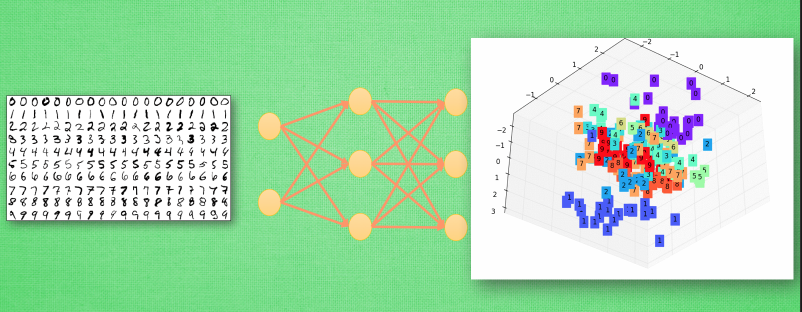
换言之，神经网络每一层的输出都相当于一个我们人类看不懂但计算机能看懂的特征描述子。而这个神经网络本身则相当于一个提取特征的算法。